In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import dopioe, smooth, robust_smooth, fit_psi_params, psi_params, find_directional_radii, axis_ratio, dopioe_pipeliner


### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_IMOS_drifters.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


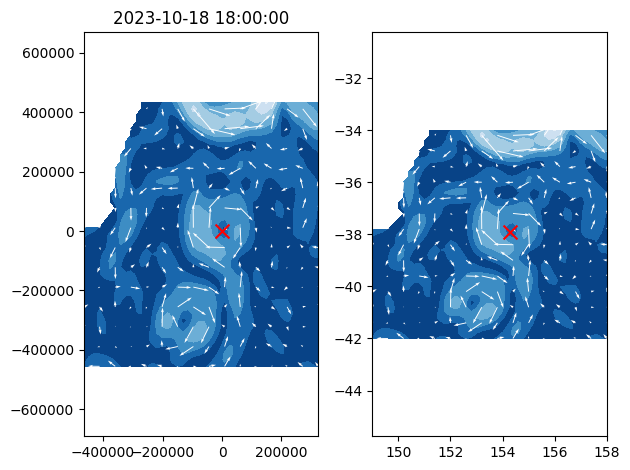

In [3]:
t_idx = 0
time = list(dic_ssh_data.keys())[t_idx]
dic = dic_ssh_data[time]
ut, vt = dic['u'], dic['v']

fig, axs = plt.subplots(1, 2)

axs[0].contourf(x_ssh, y_ssh, np.hypot(ut, vt), cmap='Blues_r')
spac = 3
axs[0].quiver(x_ssh[::spac, ::spac], y_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac], color='w')
axs[0].scatter(0,0, marker='x', color='r', s=100)
axs[0].axis('equal'); axs[0].set_title(time)

axs[1].contourf(lon_ssh, lat_ssh, np.hypot(ut, vt), cmap='Blues_r')
spac = 3
axs[1].quiver(lon_ssh[::spac, ::spac], lat_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac], color='w')
axs[1].scatter(theta_mean, phi_mean, marker='x', color='r', s=100)
axs[1].axis('equal'); axs[0].set_title(time)
# axs[1].set_xlim(152, 156); axs[1].set_ylim(-39, -36);

plt.tight_layout()



In [4]:
xc_pre, yc_pre = 0.0, 0.0

rows, dic_params = [], {}
times = list(dic_ssh_data.keys())

for k, time in enumerate(times):
    dic = dic_ssh_data[time]
    ut, vt = dic['u'], dic['v']

    xc, yc, w, Q, Rc, psi0, A, R, df = dopioe_pipeliner(xc_pre, yc_pre, 'CE', ut.T, vt.T, x_ssh.T, y_ssh.T, r=50000)

    if (np.hypot(xc - xc_pre, yc - yc_pre) < 100000.0) and (np.sign(w) < 0):

        rows.append(dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, A=A, R=R, Time=time))
        xc_pre, yc_pre = xc, yc
        dic_params[time] = df
    else:
        break  # or: continue

df_res = pd.DataFrame(rows, columns=['xc','yc','w','Q','Rc','psi0','A','R','Time'])


In [5]:
def combine_with_adjacent(dfs: dict, order=None, k=1, how='outer', include_self=True, ignore_index=True, dedup=False):
    """
    Build a new dict with the same keys where each value is the concat of its
    own DataFrame and its k adjacent neighbours in `order`.

    Parameters
    ----------
    dfs : dict[key -> pd.DataFrame]
        Original mapping.
    order : list | None
        Sequence defining adjacency. If None, uses dict insertion order.
        If None and keys are sortable, falls back to sorted(dfs).
    k : int
        Number of neighbours on each side to include (window radius).
    how : {'outer','inner'}
        Join type used by pd.concat to align columns.
    include_self : bool
        If False, excludes the key’s own DataFrame (rare, but supported).
    ignore_index : bool
        Passed to pd.concat.
    dedup : bool
        If True, drop duplicate rows after concat.

    Returns
    -------
    dict[key -> pd.DataFrame]
    """
    if order is None:
        # Try insertion order; if keys not ordered, fall back to sorted if possible
        try:
            order = list(dfs.keys())
        except Exception:
            order = None
    if order is None:
        try:
            order = sorted(dfs.keys())
        except Exception:
            raise ValueError("Provide `order` to define adjacency.")

    idx_map = {k_: i for i, k_ in enumerate(order)}
    out = {}

    for key in order:
        i = idx_map[key]
        left = max(0, i - k)
        right = min(len(order), i + k + 1)
        window_keys = order[left:right]
        if not include_self:
            window_keys = [wk for wk in window_keys if wk != key]

        frames = [dfs[wk] for wk in window_keys]
        combined = pd.concat(frames, axis=0, join=how, ignore_index=ignore_index, sort=False)
        if dedup:
            combined = combined.drop_duplicates()
        out[key] = combined

    return out

new_dfs = combine_with_adjacent(dic_params, k=3)

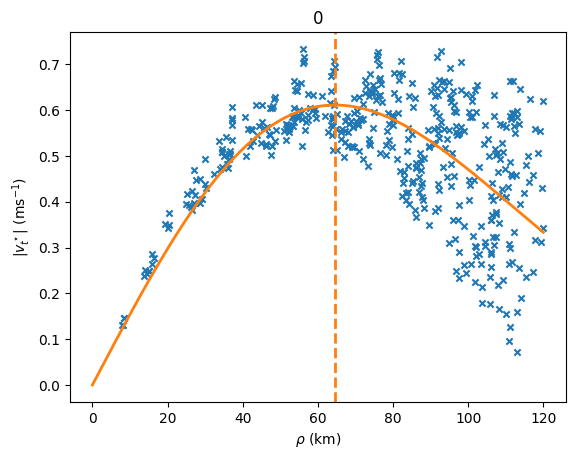

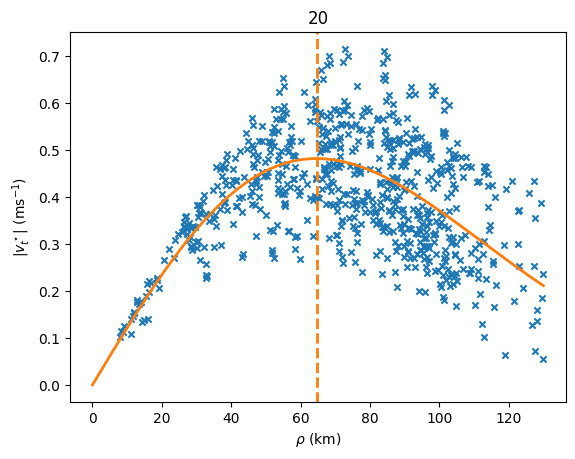

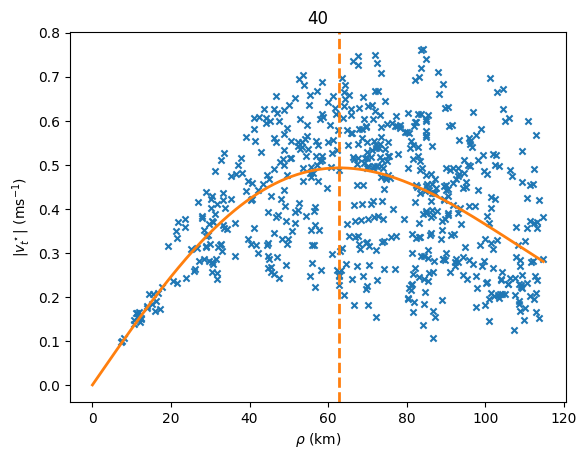

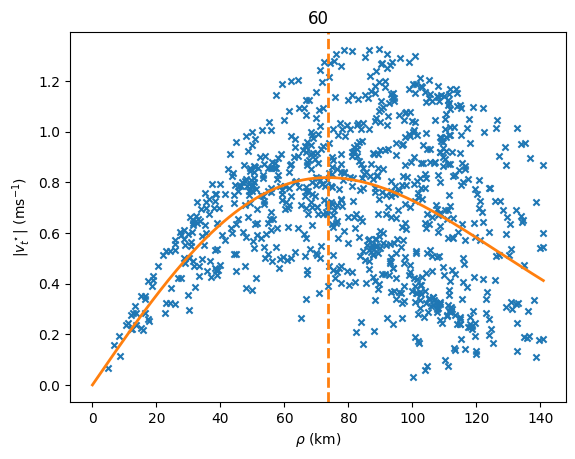

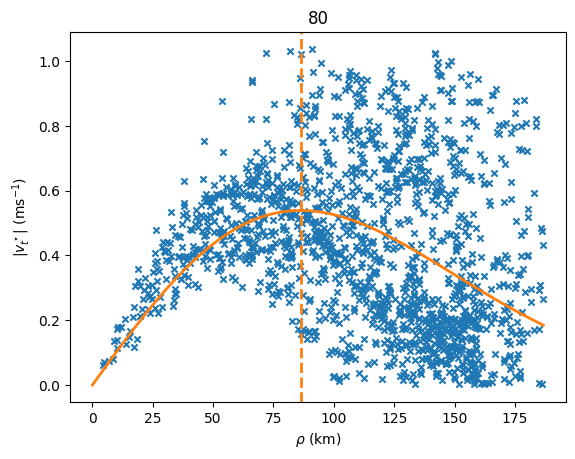

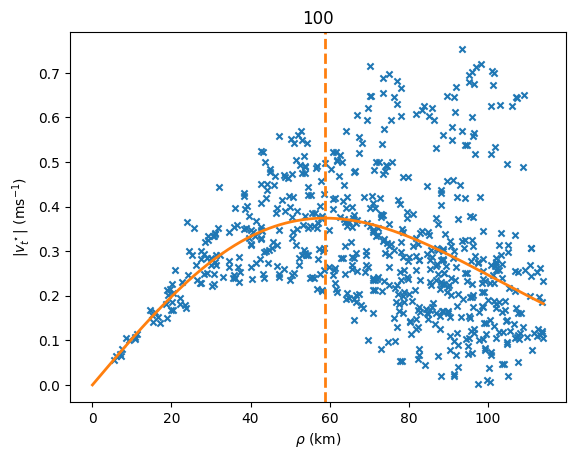

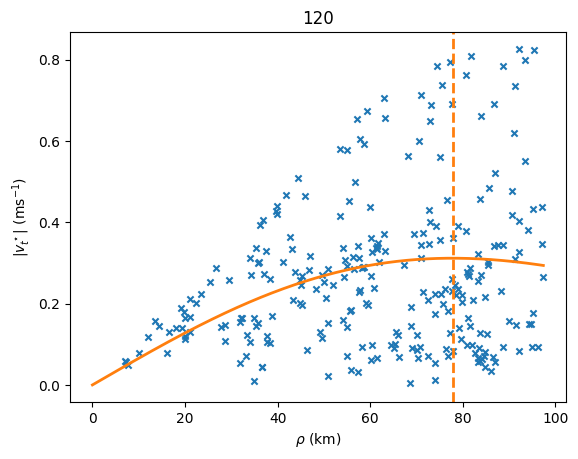

In [6]:
Rcs, psi0s, As = [], [], []
r2_2s = []
for k, time in enumerate(new_dfs.keys()):
    df = new_dfs[time].copy()
    df = df[df.vt <= 0]
    if k % 20 == 0:
        _, ax = plt.subplots()
        fit_psi_params(df.rho2/1e6, df.Qr/1e3, df.vt, r2_flag=True, 
                                             plot=True, Rc_max=1e6, ax=ax) 
        ax.set_ylabel(r'$|v_t^\star|$ (ms$^{-1}$)')
        ax.set_xlabel(r'$\rho$ (km)'); ax.set_title(f'{k}')
        # print(k)
    
    Rc_opt, psi0_opt, A_opt, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, r2_flag=True, 
                                             plot=False, Rc_max=1e6) 
        
    Rcs.append(Rc_opt); psi0s.append(psi0_opt); As.append(A_opt)
    r2_2s.append(r2_2)
df_res['Rc_opt'] = Rcs; df_res['psi0_opt'] = psi0s; df_res['A_opt'] = As
df_res['r2_2'] = r2_2s


(np.float64(-342500.0788806353),
 np.float64(21065.181833367184),
 np.float64(-10712.166913071927),
 np.float64(165338.00173037557))

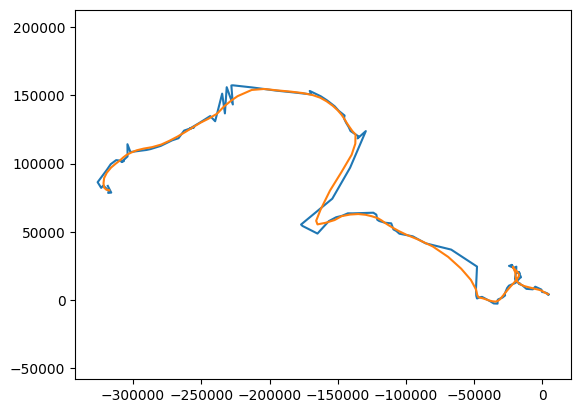

In [7]:
wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)

plt.axis('equal')


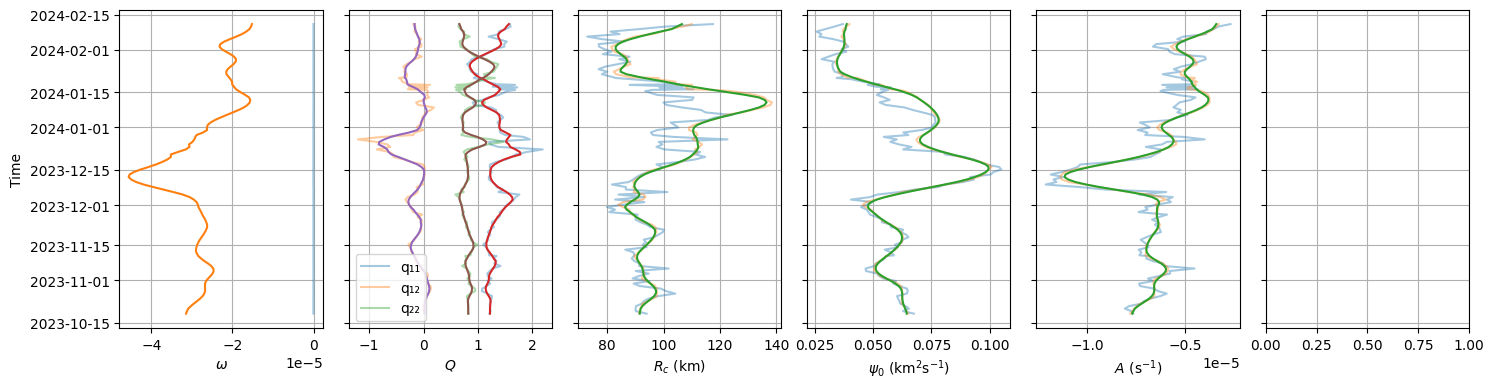

In [8]:
wdw = 5
# df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc_opt, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['spsi0'] = smooth(df_res.psi0_opt, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A_opt, df_res.Time, window=wdw, num=len(df_res)) 


# Optimal 
df_res['sw'] = 2*df_res.sA*(df_res.sq11 + df_res.sq22)
df_res['spsi0'] = -df_res.sA*df_res.sRc**2

fig, axs = plt.subplots(1, 6, figsize=(15,4), sharey=True)
alpha = .4

axs[0].plot(df_res.w, df_res.Time, alpha=alpha)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel(r'$\omega$')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂', alpha=alpha)
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel(r'$Q$')
axs[1].legend()

axs[2].plot(df_res.Rc/1e3, df_res.Time, alpha=alpha)
axs[2].plot(df_res.Rc_opt/1e3, df_res.Time, alpha=alpha)
axs[2].plot(df_res.sRc/1e3, df_res.Time)
axs[2].set_xlabel(r'$R_c$ (km)')

axs[3].plot(df_res.psi0/1e6, df_res.Time, alpha=alpha)
axs[3].plot(df_res.psi0_opt/1e6, df_res.Time, alpha=alpha)
axs[3].plot(df_res.spsi0/1e6, df_res.Time)
axs[3].set_xlabel(r'$\psi_0$ (km$^2$s$^{-1}$)')

axs[4].plot(df_res.A, df_res.Time, alpha=alpha)
axs[4].plot(df_res.A_opt, df_res.Time, alpha=alpha)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel(r'$A$ (s$^{-1}$)')

# axs[5].plot(df_res.r2_1, df_res.Time)
# axs[5].plot(df_res.r2_2, df_res.Time)
# axs[5].set_xlabel(r'$r^2$')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


In [9]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy)
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


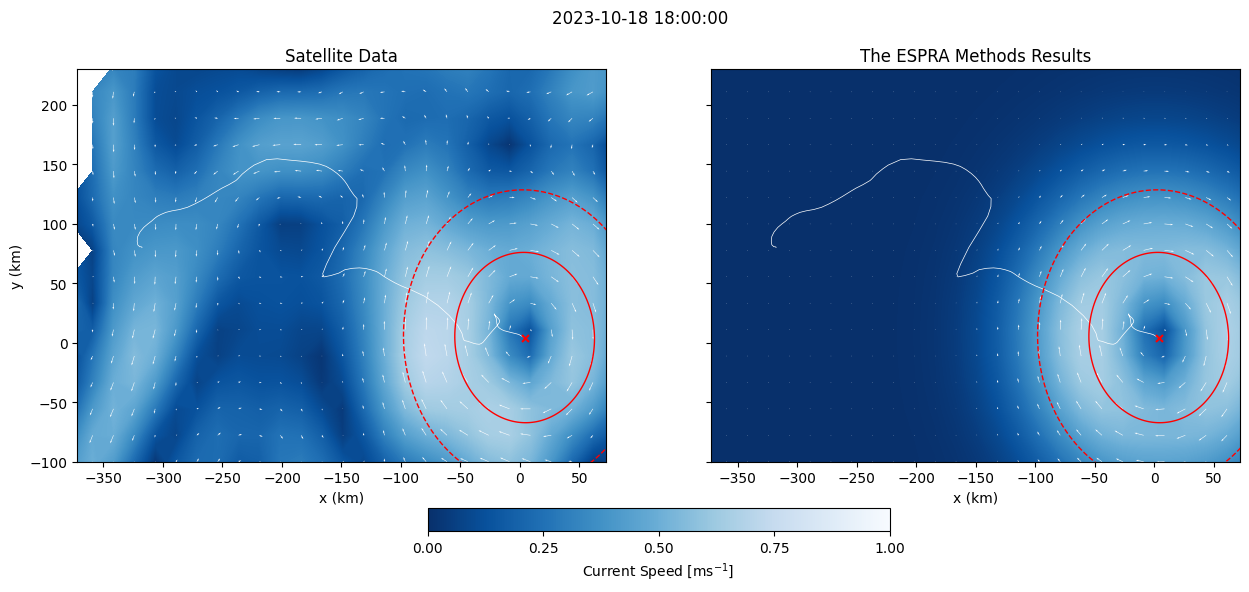

In [10]:
# t_idx = 10

x_rho, y_rho = np.linspace(X.min(), X.max(), 501), np.linspace(Y.min(), Y.max(), 501)
X_rho, Y_rho = np.meshgrid(x_rho, y_rho)

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)


# data & masks
sadcp_time = pd.Timestamp('2023-10-19 15:05:34.950679808')
# closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time)) 
closest = min(tim_ssh, key=lambda tt: abs(tt - sadcp_time)) 
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)


# data = df_res.iloc[t_idx]
data = df_res[df_res.Time==closest].iloc[0]





# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
# vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
vmax = 1
cmap = 'Blues_r'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[0].quiver(x_ssh[::spac, ::spac]/1e3, y_ssh[::spac, ::spac]/1e3,
              ut_mask[::spac, ::spac], vt_mask[::spac, ::spac], width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = X_rho/1e3 - data.sxc/1e3, Y_rho/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
# axs[0].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[((data.R*1.75)/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
# axs[1].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[((data.R*1.75)/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


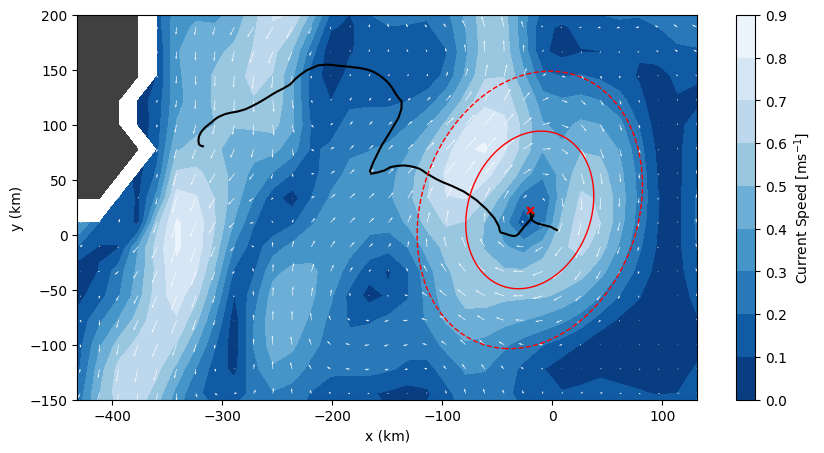

In [11]:
t_idx = 24

data = df_res.iloc[t_idx]

closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-200)&(y_ssh/1e3<=230)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

cmap = 'Blues_r'

fig, ax = plt.subplots(figsize=(10, 5))

cf = ax.contourf(x_ssh/1e3, y_ssh/1e3, spd1, cmap=cmap)

spac = 1
ax.quiver(x_ssh[::spac, ::spac]/1e3, y_ssh[::spac, ::spac]/1e3,
          ut_mask[::spac, ::spac], vt_mask[::spac, ::spac],
          width=.001, scale=30, color='w')

ax.plot(df_res.sxc/1e3, df_res.syc/1e3, lw=1.5, color='k')

dx_ell, dy_ell = X_rho/1e3 - data.sxc/1e3, Y_rho/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2

ax.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', linewidths=1)
# ax.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2], colors='r', linewidths=1, linestyles='--')
ax.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.R*1.75/1e3)**2], colors='r', linewidths=1, linestyles='--')

ax.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)

mask_nan = np.zeros_like(ut_mask)
mask_nan = np.where(np.isnan(ut_mask) & mask, mask_nan, np.nan)
ax.contourf(x_ssh/1e3, y_ssh/1e3, mask_nan, cmap='grey')

ax.axis('equal')
ax.set_xlim(-400, 100)
ax.set_ylim(-150, 200)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
# ax.set_title(f'{closest}')

cbar = fig.colorbar(cf, ax=ax)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
# cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))

plt.show()


10.87289181533084


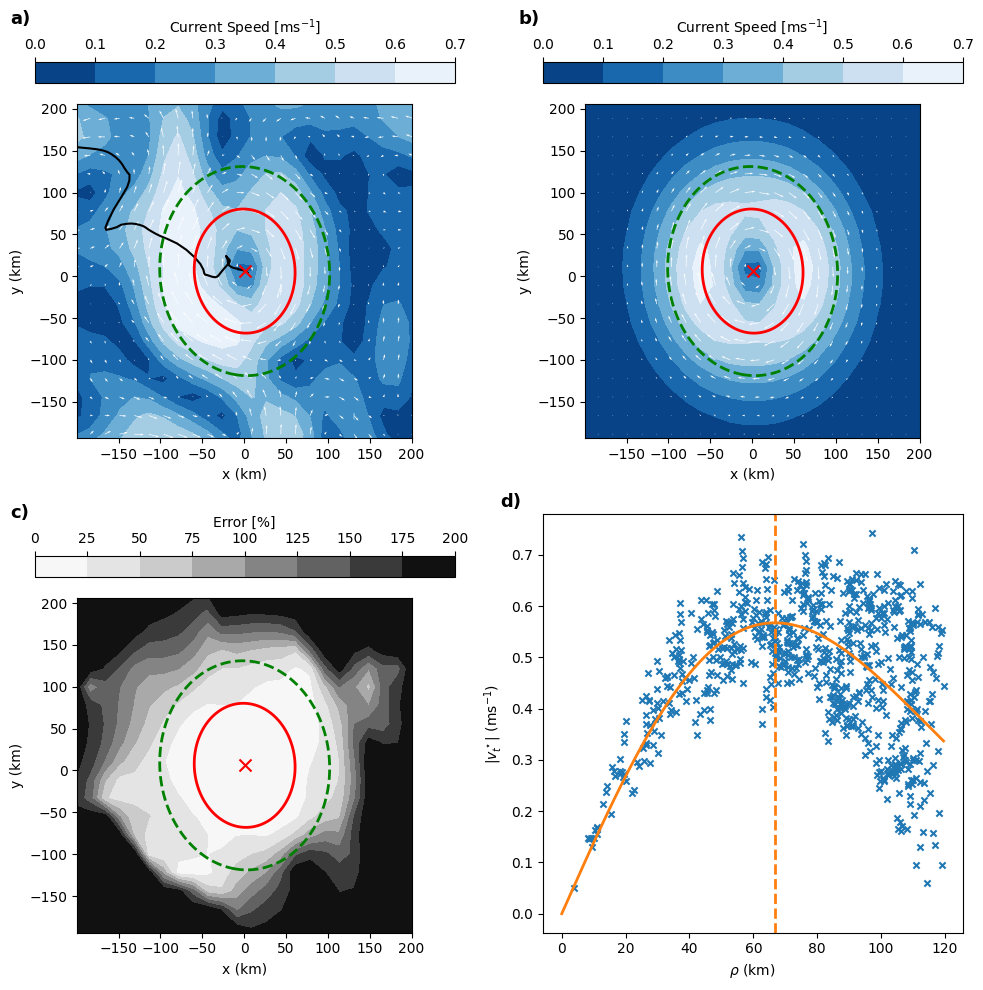

In [12]:
t_idx = 5

data = df_res.iloc[t_idx]
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

# xlim, ylim = (-200, 150), (-150, 200)
gap = 200
xlim = (data.sxc/1e3-gap, data.sxc/1e3+gap)
ylim = (data.syc/1e3-gap, data.syc/1e3+gap)

# mask
mask = (x_ssh/1e3 >= xlim[0]-50) & (x_ssh/1e3 <= xlim[1]+50) & \
       (y_ssh/1e3 >= ylim[0]-50) & (y_ssh/1e3 <= ylim[1]+50)

ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

cmap = 'Blues_r'
width, scale = .002, 15
lw = 2
fig, axs = plt.subplots(2,2, figsize=(10, 10))

# =====================
# ---- axs[0,0] -------
# =====================
ax1 = axs[0,0]
cf = ax1.contourf(x_ssh/1e3, y_ssh/1e3, spd1, cmap=cmap)

ax1.quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=width, scale=scale, color='w')
ax1.plot(df_res.sxc/1e3, df_res.syc/1e3, lw=1.5, color='k')
dx_ell, dy_ell = X_rho/1e3 - data.sxc/1e3, Y_rho/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2

dx, dy = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy+ data.sq22*dy**2

ax1.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', linewidths=lw)
# ax1.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2], colors='m', linewidths=lw, linestyles='--')
ax1.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.R*1.75/1e3)**2], colors='g', linewidths=lw, linestyles='--')

ax1.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=75, zorder=3)
# ax1.axis('equal')
ax1.set_aspect('equal', adjustable='box');
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

cbar = fig.colorbar(cf, ax=ax1, location='top')
cbar.set_label(r'Current Speed [ms$^{-1}$]')
ax1.text(-0.2, 1.28, 'a)', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')


# =====================
# ---- axs[0,1] -------
# =====================
u, v = U[:,:,t_idx], V[:,:,t_idx]
# u_mask, v_mask = np.where(mask, u, np.nan), np.where(mask, v, np.nan)
u_mask, v_mask = u, v
spd2 = np.hypot(u_mask, v_mask)
spd2_cpy = spd2.copy()
spd2_cpy[0,0] = np.nanmax(spd1)

ax2 = axs[0,1]
cf2 = ax2.contourf(X/1e3, Y/1e3, spd2_cpy, cmap=cmap)

ax2.quiver(X/1e3, Y/1e3, u_mask, v_mask, width=width, scale=scale, color='w')
ax2.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=75, zorder=3)
ax2.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', linewidths=lw, zorder=3)
# ax2.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2], colors='m', linewidths=lw, linestyles='--', zorder=3)
ax2.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[((data.R*1.75)/1e3)**2], colors='g', linewidths=lw, linestyles='--', zorder=3)

# ax2.axis('equal')
ax2.set_aspect('equal', adjustable='box');
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.set_xlim(*xlim)
ax2.set_ylim(*ylim)

cbar2 = fig.colorbar(cf2, ax=ax2, location='top')
cbar2.set_label(r'Current Speed [ms$^{-1}$]')
ax2.text(-0.2, 1.28, 'b)', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')


# =====================
# ---- axs[1,0] (Vector SMAPE) ---
# =====================
eps = 1e-6

# obs/SSH (already masked): ut_mask, vt_mask
# model: u_mask, v_mask  (same grid as X,Y)
E_mag = np.hypot(u_mask - ut_mask, v_mask - vt_mask)                         # |Δv|
mag1  = np.hypot(ut_mask, vt_mask)                                           # |v_obs|
mag2  = np.hypot(u_mask,  v_mask)                                            # |v_mod|
SM_vec = 100.0 * E_mag / (0.5*(mag1 + mag2) + eps)

ax3 = axs[1,0]
cf3 = ax3.contourf(X/1e3, Y/1e3, SM_vec, cmap='Greys', levels=np.linspace(0, 200, 9))
ax3.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=75, zorder=3)
ax3.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', linewidths=lw, zorder=3)
# ax3.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2], colors='m', linewidths=lw, linestyles='--', zorder=3)
ax3.contour(X_rho/1e3, Y_rho/1e3, rho2_ell, levels=[((data.R*1.75)/1e3)**2], colors='g', linewidths=lw, linestyles='--', zorder=3)
ax3.set_aspect('equal', adjustable='box')
ax3.set_xlabel('x (km)')
ax3.set_ylabel('y (km)')
ax3.set_xlim(*xlim); ax3.set_ylim(*ylim)
cbar3 = fig.colorbar(cf3, ax=ax3, location='top')
cbar3.set_label(r'Error [%]')
ax3.text(-0.2, 1.28, 'c)', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
print(np.nanmean(np.where(rho2<=(data.sRc/1e3)**2/2, SM_vec, np.nan)))


# =====================
# ---- axs[1,1] -------
# =====================
ax4 = axs[1,1]
for k, time in enumerate(new_dfs.keys()):
    df = new_dfs[time].copy()
    df = df[df.vt <= 0]
    if k == t_idx:
        fit_psi_params(df.rho2/1e6, df.Qr/1e3, df.vt, r2_flag=True, 
                                             plot=True, Rc_max=1e6, ax=ax4) 
        ax4.set_ylabel(r'$|v_t^\star|$ (ms$^{-1}$)')
        ax4.set_xlabel(r'$\rho$ (km)'); ax4.set_title('')
ax4.text(-0.1, 1.05, 'd)', transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()



In [13]:
df_res['e'] = axis_ratio(df_res)

df_res['Data'] = 'Drifter'
df_res['Method'] = 'DOPIOE'

df_res


,xc,yc,w,Q,Rc,psi0,A,R,Time,Rc_opt,...,sq11,sq12,sq22,sRc,sA,sw,spsi0,e,Data,Method
0,4539.488165,4157.442696,-3.434076e-08,"[[1.2079366838630883, 0.00977264388685283], [0...",93956.671362,67523.658767,-0.000008,68580.837974,2023-10-18 18:00:00,91329.717118,...,1.220576,0.018950,0.819791,91505.869433,-0.000008,-0.000031,64472.039125,1.221313,Drifter,DOPIOE
1,3825.298656,4654.998019,-3.379926e-08,"[[1.2303747114949373, 0.00938288589510427], [0...",90110.239258,62889.195645,-0.000008,64240.016346,2023-10-19 18:00:00,91470.246256,...,1.219537,0.014074,0.820407,91661.213681,-0.000008,-0.000031,64216.969937,1.219838,Drifter,DOPIOE
2,4462.700274,3771.021802,-3.660927e-08,"[[1.2237615804752704, 0.03997376870601148], [0...",90012.393093,65419.186273,-0.000008,68603.603690,2023-10-20 18:00:00,91743.401403,...,1.219781,0.014746,0.820224,91847.216076,-0.000008,-0.000031,63839.222142,1.220156,Drifter,DOPIOE
3,2714.849513,5202.738506,-3.515460e-08,"[[1.2154964441830178, -0.005799314650821756], ...",90206.149677,63957.550304,-0.000008,64252.556710,2023-10-21 18:00:00,92149.621403,...,1.223455,0.016425,0.817804,92446.855743,-0.000007,-0.000030,63322.197945,1.223950,Drifter,DOPIOE
4,2129.543657,5457.698519,-3.343226e-08,"[[1.2200132955566128, 0.021173205897814046], [...",92332.238022,61704.505228,-0.000007,68636.655378,2023-10-22 18:00:00,92448.559708,...,1.226892,0.022198,0.815831,93378.270324,-0.000007,-0.000030,62969.163179,1.227815,Drifter,DOPIOE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-321841.540872,83886.636443,-1.682149e-08,"[[1.387703300747565, -0.11899397283249373], [-...",84386.767900,28012.340927,-0.000004,51133.966646,2024-02-07 06:00:00,96079.930559,...,1.370737,-0.119850,0.745693,94975.205031,-0.000004,-0.000018,37605.619038,1.387540,Drifter,DOPIOE
117,-317762.636461,79863.585808,-1.640153e-08,"[[1.3796131586670248, -0.16882097409407257], [...",81120.027412,25809.618159,-0.000004,51139.042633,2024-02-08 06:00:00,99371.329443,...,1.418690,-0.138910,0.725048,98884.497533,-0.000004,-0.000017,37785.900721,1.438783,Drifter,DOPIOE
118,-318258.255915,78476.495239,-1.797651e-08,"[[1.5079742854651477, -0.1527337557632319], [-...",91462.669607,29635.612462,-0.000004,55432.380715,2024-02-09 06:00:00,102357.639305,...,1.490421,-0.156176,0.690655,102855.461631,-0.000004,-0.000016,38290.753004,1.516070,Drifter,DOPIOE
119,-316019.852651,78683.803592,-1.742690e-08,"[[1.5996074877728637, -0.15024593937669123], [...",100551.205726,33538.994644,-0.000003,55644.525596,2024-02-10 06:00:00,106666.963043,...,1.522256,-0.164890,0.677156,104734.113446,-0.000004,-0.000015,38417.689103,1.550488,Drifter,DOPIOE


In [14]:
df_res.to_pickle("/srv/scratch/z5297792/MRes_thesis_ESP_application_files/df_res_SAT_DOPIOE.pkl")
